# Solving the Traveling Salesman  Problem using Local Search

Points: 10

## The Traveling Salesman Problem

Problem definition (see [TSP on Wikipedia](https://en.wikipedia.org/wiki/Travelling_salesman_problem)):

* __Goal:__ Find the shortest tour visiting each of $n$ cities exactly once and returning back to the starting city. Given are pairwise distances between cities, where $d_{i,j}$ is the distance from city $i$ to city $j$. 

* __State space:__ Each state represents a tour. The cities are numbered and a tour can be expressed as vector  $\pi$ with the order in which the cities are visited (a [permutation](https://en.wikipedia.org/wiki/Permutation)). That is, $\pi(1)$ is the index of the first city to visit, $\pi(2)$ the index of the second, and so on.

* __Objective function:__ Minimize the tour length. The optimization problem is to find the optimal tour $\pi^*$ through the $n$ cities and returning to the starting city:

  > minimize: $\mathrm{tourlength}(\pi) = d_{\pi(n),\pi(1)} + \sum_{i = 1}^{n-1} d_{\pi(i),\pi(i+1)}$
  > 
  > subject to: $\pi \ \text{is a valid permutation vector}$

* __Local moves:__ Exchange two cities in the order.

## Helper functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

np.set_printoptions(precision = 2)
pd.set_option('precision', 2)

# make the results repeatable
np.random.seed(1234)

In [2]:
def random_tour(n):
    """Create a random tour"""
    
    tour = list(range(n))
    random.shuffle(tour)
    return(tour)

random_tour(10)

[7, 1, 3, 5, 9, 6, 8, 2, 4, 0]

In [3]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

def random_tsp(n):
    """
    Create a random (Euclidean) traveling salesman problem. Choose n points randomly in a 1 x 1 unit square and calulates a 
    pairwise Euclidean distance matrix.
    """
    
    pos = pd.DataFrame({
        "x" : np.random.uniform(size = n),
        "y" : np.random.uniform(size = n)
    })
    
    dist = squareform(pdist(pos))
    
    return({"pos": pos, "dist": dist})
    
tsp = random_tsp(10)

print(f"Positions:\n{tsp['pos']}")
print(f"Distance matrix:\n{pd.DataFrame(tsp['dist'])})")

Positions:
      x     y
0  0.19  0.36
1  0.62  0.50
2  0.44  0.68
3  0.79  0.71
4  0.78  0.37
5  0.27  0.56
6  0.28  0.50
7  0.80  0.01
8  0.96  0.77
9  0.88  0.88
Distance matrix:
      0     1     2     3     4     5     6     7     8     9
0  0.00  0.45  0.41  0.69  0.59  0.22  0.17  0.70  0.87  0.86
1  0.45  0.00  0.26  0.27  0.20  0.35  0.35  0.52  0.43  0.46
2  0.41  0.26  0.00  0.35  0.46  0.21  0.24  0.76  0.53  0.48
3  0.69  0.27  0.35  0.00  0.34  0.53  0.55  0.70  0.18  0.19
4  0.59  0.20  0.46  0.34  0.00  0.54  0.52  0.36  0.44  0.52
5  0.22  0.35  0.21  0.53  0.54  0.00  0.06  0.76  0.72  0.68
6  0.17  0.35  0.24  0.55  0.52  0.06  0.00  0.72  0.73  0.71
7  0.70  0.52  0.76  0.70  0.36  0.76  0.72  0.00  0.77  0.87
8  0.87  0.43  0.53  0.18  0.44  0.72  0.73  0.77  0.00  0.14
9  0.86  0.46  0.48  0.19  0.52  0.68  0.71  0.87  0.14  0.00)


In [4]:
def tour_length(tsp, tour):
    """Caclulate the length of a tour, i.e., the objective function."""
    
    # make sure tour is a Python list (not an array or a numpy.array)
    if not isinstance(tour, list): tour = tour.tolist()
    
    tl = 0
    dist = tsp["dist"]
    
    for i in range(len(tour)-1):
        tl += dist[tour[i], tour[i+1]]
    
    tl += dist[tour[-1], tour[0]]
    
    return(tl)
        
tour = random_tour(10)
tour_length(tsp, tour)

5.0309935213217045

Tour length: 5.03


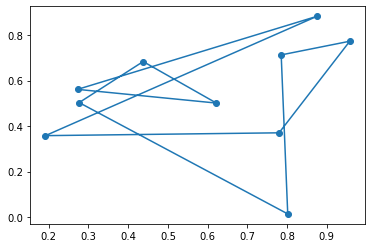

In [5]:
def show_tsp(tsp, tour = None):  
    """display the traveling salesman problem and a tour."""
    
    pos = tsp["pos"]
    
    plt.scatter(pos["x"], pos["y"])
    
    if tour is not None:
        # make sure tour is a Python list (not an array or a numpy.array)
        if not isinstance(tour, list): tour = tour.tolist()
        
        print(f"Tour length: {round(tour_length(tsp, tour), 2)}")
        
        pos_ = pos.reindex(tour)
        pos_ = pos_.append(pos_.head(1))
        plt.plot(pos_["x"], pos_["y"])
    
    plt.show()
    
show_tsp(tsp, tour)

## Use R to find a solution

Load rpy2, make sure the R [TSP package](https://CRAN.R-project.org/package=TSP) is installed and prepare the distance matrix.

In [6]:
%load_ext rpy2.ipython

%R if(!"TSP" %in% rownames(installed.packages())) install.packages("TSP", repos="http://cran.us.r-project.org")
%R if(!"microbenchmark" %in% rownames(installed.packages())) install.packages("microbenchmark", repos="http://cran.us.r-project.org")

d = tsp["dist"]

Solve the TSP using [`solve_TSP`](https://www.rdocumentation.org/packages/TSP/versions/1.1-10/topics/solve_TSP) with the default heuristic. Note that 2-opt is steepest ascend hill climbing with exchanging two cities. `rep = 10` means 10 random restarts.

In [7]:
%%R -i d -o tour

library("TSP")

tsp <- TSP(d)
print(tsp)

tour <- solve_TSP(tsp, rep = 10)
print(tour)

# R starts index with 1, but Python starts at 0
tour <- tour - 1L

object of class ‘TSP’ 
10 cities (distance ‘unknown’) 
object of class ‘TOUR’ 
result of method ‘arbitrary_insertion+two_opt_rep_10’ for 10 cities
tour length: 2.763574 


Tour length: 2.76


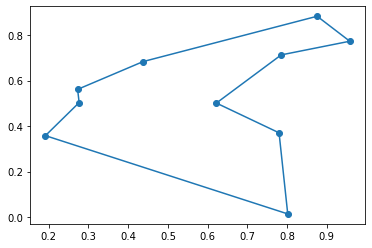

In [8]:
show_tsp(tsp, tour)

How long does it take to solve the problem?

In [9]:
%%R -i d

library("microbenchmark")
d <- TSP(d)


microbenchmark(solve_TSP(d, rep = 10))

Unit: milliseconds
                   expr      min     lq     mean   median       uq      max
 solve_TSP(d, rep = 10) 5.709245 5.7846 7.105309 6.319347 8.212746 11.91373
 neval
   100


## Steepest-ascend Hill Climbing Search [3 Points]

Calculate the objective function for all local moves (move each queen within its column) and always choose the best among all local moves.

In [10]:
# Code goes here

## Steepest-ascend Hill Climbing Search with Random Restarts [1 Point]

Steepest-ascend with random restarts.

In [11]:
# Code goes here

## Stochastic Hill Climbing [1 Points]

Chooses randomly from among all uphill moves.

In [12]:
# Code goes here

## Stochastic Hill Climbing (First-choice) [1 Point]

First-choice hill climbing is a type of stochastic hill climbing that generates one random local neighbor at a time and accept it if it has a better objective function value than the current state.

### Local Moves
I implement the following three different local move strategies: 
* Swap two random cities. 
* Swap two neighboring cities.
* Reverse the subtour between two cities.

In [13]:
def move_swap(tour):
    new_tour = tour.copy()
    
    # np.random.randint is inclusive lower limit and exclusive upper limit
    [a, b] = np.random.randint(0, len(tour), 2)
    #print(f"a={a}, b={b}")
    
    new_tour[a] = tour[b]
    new_tour[b] = tour[a]
    return(new_tour)

print(move_swap(list(range(10))))
print(move_swap(list(range(10))))
print(move_swap(list(range(10))))

[7, 1, 2, 3, 4, 5, 6, 0, 8, 9]
[9, 1, 2, 3, 4, 5, 6, 7, 8, 0]
[0, 1, 3, 2, 4, 5, 6, 7, 8, 9]


In [14]:
def move_swap_neighbors(tour):
    new_tour = tour.copy()
    
    a = np.random.randint(0, len(tour)-1, 1)[0]
    if a > 0: b = a+1
    else: b = len(tour)-1  
    #print(f"a={a}, b={b}")
    
    new_tour[a] = tour[b]
    new_tour[b] = tour[a]
    return(new_tour)

print(move_swap_neighbors(list(range(10))))
print(move_swap_neighbors(list(range(10))))
print(move_swap_neighbors(list(range(10))))

[0, 1, 2, 4, 3, 5, 6, 7, 8, 9]
[0, 2, 1, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 4, 3, 5, 6, 7, 8, 9]


In [15]:
def move_reverse(tour):
    new_tour = tour.copy()
    
    ab = np.random.randint(0, len(tour)+1, 2)
    ab.sort()
    #print(f"a={ab[0]}, b={ab[1]}")
        
    new_tour[ab[0]:ab[1]] = new_tour[ab[0]:ab[1]][::-1]
    return(new_tour)

print(move_reverse(list(range(10))))
print(move_reverse(list(range(10))))
print(move_reverse(list(range(10))))

[0, 9, 8, 7, 6, 5, 4, 3, 2, 1]
[0, 1, 2, 6, 5, 4, 3, 7, 8, 9]
[0, 9, 8, 7, 6, 5, 4, 3, 2, 1]


### Search Algorithm

I don't know what the optimal tour is so I run the algorithm for at most `max_steps` steps, and stop if there is no improvement for at least `stop_after` steps.

In [16]:
def FCSHC(tsp, tour = None, local_move_method = move_swap, 
         max_steps = 1000000, stop_after = 1000, verbose = True, keep_history = False):
    
    n = len(tsp['pos'])
    
    if keep_history: history = list() 
    
    # 1. initialize current tour
    # current tour = initial tour (random if no tour is given)
    if not tour is None:
        current_tour = tour
    else:
        current_tour = random_tour(n)
    
    
    # initial tour length
    current_length = tour_length(tsp, current_tour)    
    if verbose: print(f"initial tour length: {current_length}")
    
    # step when we last improved the length
    last_improvement_step = 0
    
    # 2. repeat local moves
    for step in range(max_steps):
        
        new_tour = local_move_method(current_tour)
        new_length = tour_length(tsp, new_tour)  
        
        # check if the new tour is better   
        if new_length < current_length: 
            current_tour = new_tour
            current_length = new_length
            last_improvement_step = step
            if verbose: print(f"step: {step} - new tour length: {current_length}")
    
        if keep_history: history.append(current_length)
    
        # stop if we did not improve for stop_after steps
        if step - last_improvement_step > stop_after: 
            if verbose: print(f"step: {step} - no improvement for {stop_after} steps.")
            break
    
    
    if keep_history: return(current_tour, history)
    return(current_tour)

### Comparison of Local Move Strategies Using a Single Problem

Tour length: 5.94


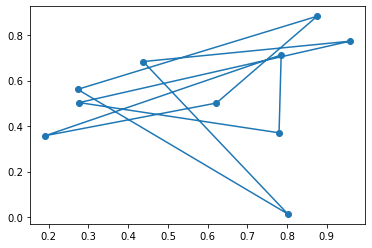

In [17]:
initial_tour = random_tour(len(tsp['pos']))
show_tsp(tsp, initial_tour)

initial tour length: 5.9356567943169605
step: 0 - new tour length: 5.797463755708917
step: 1 - new tour length: 5.183022997361501
step: 2 - new tour length: 5.1022087087488295
step: 5 - new tour length: 5.0697368722522365
step: 6 - new tour length: 4.71189693474375
step: 11 - new tour length: 4.25709323935485
step: 13 - new tour length: 4.251505518750177
step: 14 - new tour length: 4.2307169842915
step: 21 - new tour length: 4.159801377604809
step: 22 - new tour length: 3.977399041055161
step: 23 - new tour length: 3.637357195365694
step: 24 - new tour length: 3.582428400650673
step: 29 - new tour length: 3.563152540720248
step: 30 - new tour length: 3.346765162396843
step: 42 - new tour length: 3.2462496708860544
step: 115 - new tour length: 2.9062078251965877
step: 1116 - no improvement for 1000 steps.
CPU times: user 42.8 ms, sys: 16.7 ms, total: 59.4 ms
Wall time: 50 ms
Tour length: 2.91


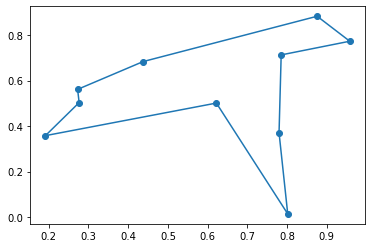

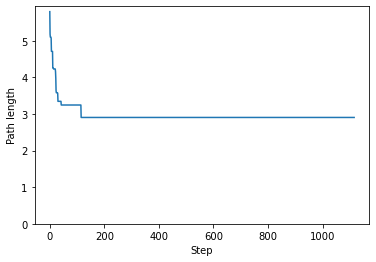

In [18]:
%time tour, history_swap = FCSHC(tsp, initial_tour, local_move_method = move_swap, keep_history = True)
show_tsp(tsp, tour)

plt.plot(range(len(history_swap)), history_swap)
plt.xlabel("Step")
plt.ylabel("Path length")
plt.ylim(bottom = 0)
plt.show()

initial tour length: 5.9356567943169605
step: 0 - new tour length: 5.915324433686929
step: 1 - new tour length: 5.436858671250661
step: 3 - new tour length: 4.90389533999578
step: 5 - new tour length: 4.871171816180199
step: 11 - new tour length: 4.370589475028713
step: 1012 - no improvement for 1000 steps.
CPU times: user 43.9 ms, sys: 4.72 ms, total: 48.6 ms
Wall time: 39.2 ms
Tour length: 4.37


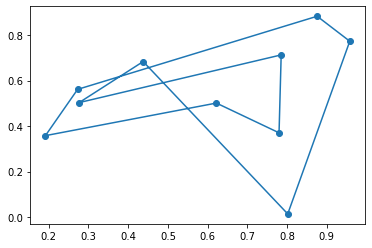

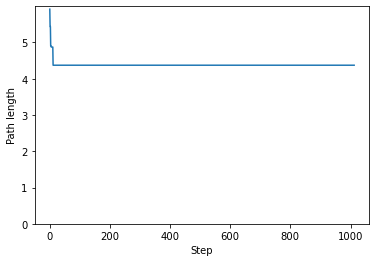

In [19]:
%time tour, history_swap_neighbors = FCSHC(tsp, initial_tour, local_move_method = move_swap_neighbors, keep_history = True)
show_tsp(tsp, tour)

plt.plot(range(len(history_swap_neighbors)), history_swap_neighbors)
plt.xlabel("Step")
plt.ylabel("Path length")
plt.ylim(bottom = 0)
plt.show()

initial tour length: 5.9356567943169605
step: 0 - new tour length: 5.068859350897879
step: 1 - new tour length: 4.979648600277604
step: 4 - new tour length: 4.309036587802521
step: 5 - new tour length: 4.252729308381401
step: 6 - new tour length: 4.220257471884808
step: 9 - new tour length: 3.7601481828348846
step: 15 - new tour length: 3.7601481828348837
step: 17 - new tour length: 3.6578974571531457
step: 28 - new tour length: 3.4742806142021774
step: 44 - new tour length: 3.3871329297226427
step: 47 - new tour length: 2.983841892720729
step: 48 - new tour length: 2.7635735777577013
step: 1049 - no improvement for 1000 steps.
CPU times: user 43 ms, sys: 0 ns, total: 43 ms
Wall time: 40.7 ms
Tour length: 2.76


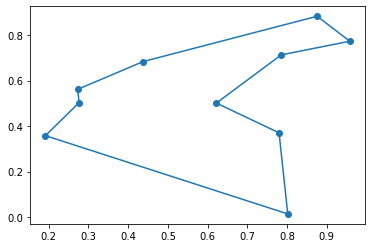

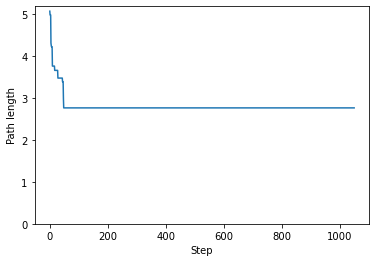

In [20]:
%time tour, history_reverse = FCSHC(tsp, initial_tour, local_move_method = move_reverse, keep_history = True)
show_tsp(tsp, tour)

plt.plot(range(len(history_reverse)), history_reverse)
plt.xlabel("Step")
plt.ylabel("Path length")
plt.ylim(bottom = 0)
plt.show()

All three learning curves

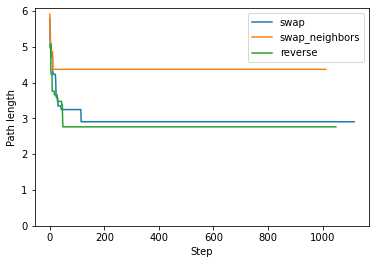

In [21]:
plt.plot(range(len(history_swap)), history_swap, label = "swap")
plt.plot(range(len(history_swap_neighbors)), history_swap_neighbors, label = "swap_neighbors")
plt.plot(range(len(history_reverse)), history_reverse, label = "reverse")
plt.xlabel("Step")
plt.ylabel("Path length")
plt.ylim(bottom = 0)
plt.legend()
plt.show()

### Comparison of Local Move Strategies

We compare the local move strategies using 100 random problems.

In [22]:
N = 100 # replications
n = 20 # number of cities

results = { 
    'swap' : np.zeros(shape = [N]),
    'swap_neighbors' : np.zeros(shape = [N]),
    'reverse' : np.zeros(shape = [N]) 
}

for i in range(N):
    tsp_test = random_tsp(n)
    initial_tour = random_tour(n)
    
    results['swap'][i] = tour_length(tsp_test, 
        FCSHC(tsp_test, initial_tour, local_move_method = move_swap, verbose = False))
    
    results['swap_neighbors'][i] = tour_length(tsp_test, 
        FCSHC(tsp_test, initial_tour, local_move_method = move_swap_neighbors, verbose = False))
    
    results['reverse'][i] = tour_length(tsp_test, 
        FCSHC(tsp_test, initial_tour, local_move_method = move_reverse, verbose = False))

    swap  swap_neighbors  reverse
0   5.01            7.89     3.99
1   3.88            8.69     3.88
2   4.21            6.98     3.54
3   4.68            8.07     4.88
4   5.52           11.43     4.61
..   ...             ...      ...
95  4.33            8.26     3.68
96  4.65            6.31     3.81
97  4.18            6.98     3.98
98  5.00            6.49     3.67
99  5.03           10.20     4.15

[100 rows x 3 columns]
swap              4.58
swap_neighbors    8.35
reverse           4.01
dtype: float64


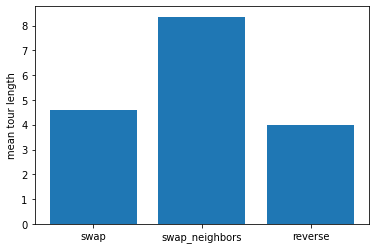

In [23]:
# compare averages
import pandas as pd
import matplotlib.pyplot as plt

results = pd.DataFrame(results)
print(results)

means = np.mean(results, axis = 0)
print(means)

plt.bar(means.keys(), means)
plt.ylabel("mean tour length")
plt.show()


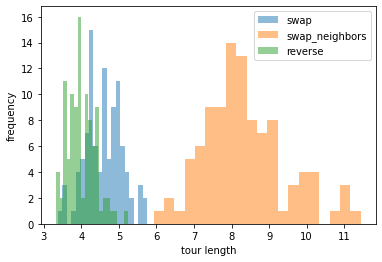

In [24]:
# histogram

plt.hist(results['swap'], bins = 20, alpha = .5)
plt.hist(results['swap_neighbors'], bins = 20, alpha = .5)
plt.hist(results['reverse'], bins = 20, alpha = .5)
plt.xlabel("tour length")
plt.ylabel("frequency")
plt.legend(labels = ["swap", "swap_neighbors", "reverse"])
plt.show()

<AxesSubplot:>

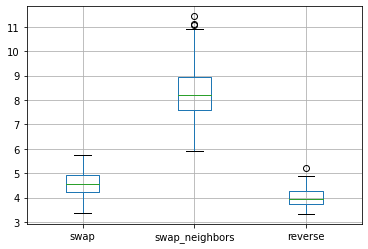

In [25]:
# boxplot (from pandas.DataFrame)

results.boxplot()

In [26]:
# is reverse better than swap?
# perform a paired t-test

from scipy import stats

stats.ttest_rel(results['swap'], results['reverse'])

Ttest_relResult(statistic=12.898792213883386, pvalue=6.374524193279588e-23)

## Simulated Annealing [2 Points]

Simulated annealing is a form of stochastic hill climbing that also allows downhill moves with a probability proportional to the temperature. This is done to avoid local optima. The temperature is decreased in every iteration following an annealing schedule.

Finding a good cooling schedule for the problem is the most challenging part of simulated annealing. Some guidance can be found [here](http://what-when-how.com/artificial-intelligence/a-comparison-of-cooling-schedules-for-simulated-annealing-artificial-intelligence/).

The initial temperature $T_0$ should be chosen such that initially any move, no matter how bad, has a high probability of being performed. For $P = exp(-\Delta E/T_0)$ we get a probability of $exp(-1) = 0.37$ if $T_0$ is equal to the worst $\Delta E$. This is typically enough.

For the schedule, $T_t = T_0 \alpha^t$ is popular with $\alpha$ less but close to 1 and $t$ being the time step. Note that this is equivalent to multiplying the current temperature with $\alpha$ at every step.

In [27]:
def schedule(t, T0, alpha):
    return(T0 * alpha ** t)

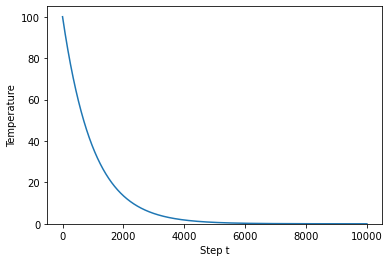

In [48]:
ts = range(0,10000)
plt.plot(ts, [schedule(t, 100, 0.999) for t in ts])
plt.xlabel("Step t")
plt.ylabel("Temperature")
plt.ylim(bottom = 0)
plt.show()

In [29]:
def SA(tsp, tour = None, local_move_method = move_reverse, 
         T0 = None, alpha = 0.999, epsilon = 1e-3, verbose = True, keep_history = False):
    
    n = len(tsp['pos'])
    
    if keep_history: history = list() 
    
    # 1. initialize current tour
    # current tour = initial tour (random if no tour is given)
    if not tour is None:
        current_tour = tour
    else:
        current_tour = random_tour(n)
    
    # initial tour length
    current_length = tour_length(tsp, current_tour)    
    if verbose: print(f"initial tour length: {current_length:3.3}")
    
    # use the worst case length. We use the maximal distance for each row of the distance matrix. 
    # This may not be a valid tour, but it is an upper limit for deltaE.
    if T0 is None:
        T0 = np.sum(np.amax(tsp["dist"], axis = 0))
    
    # 2. repeat local moves till temperature is low enough
    T = T0
    t = 0
    while T > epsilon:
        
        # calculate temperature from schedule
        T = schedule(t, T0, alpha)
        
        # create random move
        new_tour = local_move_method(current_tour)
        new_length = tour_length(tsp, new_tour)
        
        deltaE = new_length - current_length
        
        # check if the new tour is better   
        if deltaE < 0 or np.random.rand() < math.exp(-deltaE/T): 
            current_tour = new_tour
            current_length = new_length
            if verbose: print(f"step: {t} \t temp: {T:5.3f} \t deltaE: {deltaE:+3.3f} \t new tour length: {current_length:3.3f}")
      
        if keep_history: history.append(current_length)
    
        t += 1
    
    if keep_history: return(current_tour, history)
    return(current_tour)

CPU times: user 299 ms, sys: 45.2 ms, total: 344 ms
Wall time: 301 ms
Tour length: 2.76


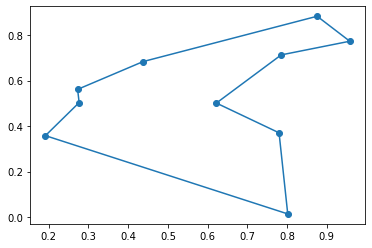

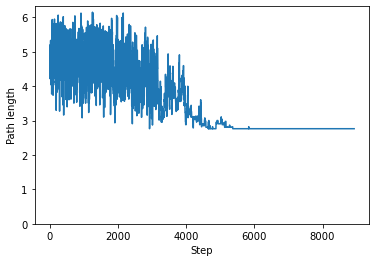

In [49]:
%time tour, history = SA(tsp, local_move_method = move_swap, alpha = 0.999, verbose = False, keep_history = True)
show_tsp(tsp, tour)

plt.plot(range(len(history)), history)
plt.xlabel("Step")
plt.ylabel("Path length")
plt.ylim(bottom = 0)
plt.show()

## Compare Performance [2 Points]

Use runtime, scalability (number of cities), and best objective function value to compare the algorithms on boards of different sizes.  

For timing you can use the `time` package.

In [31]:
import time

t0 = time.time()
print("Do something")
t1 = time.time()

print(f"This took: {(t1-t0) * 1e3} milliseconds")

Do something
This took: 0.1957416534423828 milliseconds


In [32]:
# Code and results go here

## Bonus: Genetic Algorithm [+1 Point]

In [33]:
# Code goes here